## signate 画像分類コンペ(2クラス)

In [32]:
# ライブラリの読み込み
import pandas as pd
import os
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as pl
import torchmetrics

import matplotlib.pyplot as plt
%matplotlib inline

### 初期処理

In [16]:
BASE_PATH = 'C:\\Users\\zigza\\GitFile\\signate\\package_analysis\\'
DATA_PATH = BASE_PATH + 'datasets\\'
TRAIN_PATH = DATA_PATH + 'train\\'
TEST_PATH = DATA_PATH + 'test\\'
OUT_PATH = BASE_PATH + 'out\\'

In [17]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
train_df.head()

,image_name,label
0,0000.png,0
1,0001.png,1
2,0002.png,1
3,0003.png,1
4,0004.png,0


### 画像の調査

In [18]:
print(train_df['label'].value_counts())

label
1    1182
0     994
Name: count, dtype: int64


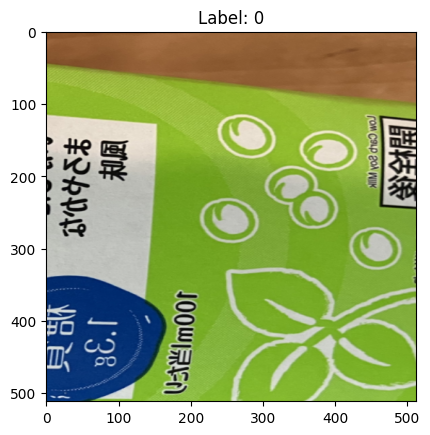

In [19]:
for idx, row in train_df.sample(n=1).iterrows():
    img = Image.open(os.path.join(TRAIN_PATH, row['image_name']))
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.show()

In [20]:
# いくつかの画像の次元と色空間を確認
for idx, row in train_df.sample(n=5).iterrows():
    img = Image.open(os.path.join(TRAIN_PATH, row['image_name']))
    
    # 画像の次元と色空間を表示
    print(f"Image: {row['image_name']}")
    print(f"Dimensions: {img.size}")
    print(f"Color space: {img.mode}")
    print()

Image: 1479.png
Dimensions: (512, 512)
Color space: RGB

Image: 1961.png
Dimensions: (512, 512)
Color space: RGB

Image: 1896.png
Dimensions: (512, 512)
Color space: RGB

Image: 0798.png
Dimensions: (512, 512)
Color space: RGB

Image: 1630.png
Dimensions: (512, 512)
Color space: RGB



### Dataset

In [21]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


# 画像の変換を定義
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a common size
    transforms.ToTensor(), # Convert images to PyTorch tensors
])

# データセットを作成
dataset = CustomDataset(dataframe=train_df, img_dir=TRAIN_PATH, transform=transform)

# DataLoaderを作成
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Batch shape: torch.Size([32, 3, 256, 256])
Label shape: torch.Size([32])
Labels: tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1])


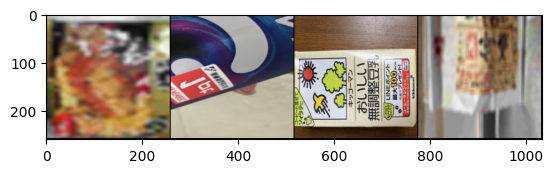

In [22]:
# DataLoaderから1バッチのデータを取得
images, labels = next(iter(train_loader))

# バッチの詳細を表示
print(f'Batch shape: {images.shape}')
print(f'Label shape: {labels.shape}')

# ラベルの一覧を表示
print(f'Labels: {labels}')

# いくつかの画像を表示
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:4]))


### CNN

In [26]:
# CNNモデル
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 128 * 128, 2)
        self.val_losses = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 128 * 128)
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        val_acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', val_acc, on_epoch=True, prog_bar=True)
        return {'val_loss': val_loss, 'val_acc': val_acc}

    def on_validation_epoch_end(self):
        # avg_loss = torch.stack(self.val_losses).mean()
        # self.log('avg_val_loss', avg_loss)
        self.val_losses = []  # Reset for the next epoch

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)



# データセットの分割
train_data, val_data = random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])

# データローダー
train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(val_data, batch_size=32)

# トレーニング
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    deterministic=True,
    callbacks=False,
    enable_progress_bar=True,
    log_every_n_steps=1
)

model = SimpleCNN()
trainer.fit(model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 448   
1 | pool  | MaxPool2d | 0     
2 | fc1   | Linear    | 524 K 
------------------------------------
524 K     Trainable params
0         Non-trainable params
524 K     Total params
2.099     Total estimated model params size (MB)


C:\Users\zigza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s, v_num=4, train_loss_step=0.0264, val_loss=1.050, val_accuracy=0.541, train_loss_epoch=0.180]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:47<00:00,  1.16it/s, v_num=4, train_loss_step=0.0264, val_loss=1.050, val_accuracy=0.541, train_loss_epoch=0.180]
